In [ ]:
# установка и активация пакетов
!pip install corus
!pip install gensim
!pip install gensim pyLDAvis
!pip install -U pymorphy2
import corus
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import sys
import numpy as np
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
import gensim.downloader as api
import gensim
from gensim import corpora
import warnings, logging
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords") 
nltk.download('punkt') 
nltk.download('wordnet') 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
# загрузка датасета РИА Новости
!wget https://github.com/RossiyaSegodnya/ria_news_dataset/raw/master/ria.json.gz

--2023-05-13 09:58:14--  https://github.com/RossiyaSegodnya/ria_news_dataset/raw/master/ria.json.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/RossiyaSegodnya/ria_news_dataset/master/ria.json.gz [following]
--2023-05-13 09:58:14--  https://media.githubusercontent.com/media/RossiyaSegodnya/ria_news_dataset/master/ria.json.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1025015063 (978M) [application/octet-stream]
Saving to: ‘ria.json.gz’

ria.json.gz         100%[===================>] 977.53M   251MB/s    in 3.7s    

2023-05-13 09:58:28 (262 MB/s) - ‘ria.json.gz’ saved [1

In [ ]:
# проверка - загрузка первой новости

from corus import load_ria

path = 'ria.json.gz'
records = load_ria(path)
next(records)

RiaRecord(
    title='большинство детей, которых пытались увезти в сша из гаити, не сироты',
    prefix='москва, 31 янв - риа новости.',
    text='большая часть из 33 детей, которых граждане сша пытались вывезти из гаити в организованный в доминиканской республике приют, не являются сиротами, сообщает в воскресенье агентство франс пресс со ссылкой на заявление представителя международной организации "детские деревни sos" (sos children\'s village), оказывающей помощь детям, оставшимся без родителей\nкак заявила агентству патрисия варгас (patricia vargas), курирующая программы "детских деревень sos" в центральной америке, мексике и на карибах, поговорив с детьми она выяснила, что родители многих из них живы. некоторые дети смогли назвать свои домашние адреса и номера телефонов, что дает возможность связаться с их родителями.\nв это воскресенье гаитянская полиция задержала десятерых граждан сша, подозреваемых в попытке без разрешения вывезти более 30 детей в доминиканскую республику.\nпре

In [ ]:
#создаём датасет

data = [next(records).text for i in range(1000)]
data[0]

'ханты-мансийский негосударственный пенсионный фонд занимает первое место в россии по числу получателей пожизненных пенсий и третье место по величине пенсионных резервов, успешно инвестируя треть из них в жилую недвижимость. об итогах работы фонда в 2009 году, об изменении стратегии развития, а также о том, какие вызовы стоят перед отраслью негосударственного пенсионного обеспечения, рассказал в интервью риа новости президент фонда максим филатов.\n- максим владимирович, осенью минула годовщина финансового кризиса, недавно начался новый, 2010 год. с какими итогами подошла отрасль негосударственного пенсионного обеспечения к этим рубежам?\n- я могу сказать, что отрасль пережила кризис достаточно успешно, наверно, как и весь финансовый сектор. более того, количество заключенных договоров по обязательному пенсионному страхованию (опс) в этом году превысило прошлогодний уровень, и мы увидим вскоре очень серьезное увеличение пенсионных накоплений в управлении фондами.\nбольшое число фондов,

In [ ]:
#опущение предупреждений и стоп-слова
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
stop_words = stopwords.words("russian")

In [ ]:
lem = WordNetLemmatizer()
def process_words(texts):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts] # lowercase, tokenize
    texts_out = []
    for sent in texts:
        texts_out.append([lem.lemmatize(token) for token in sent])
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]       
    return texts_out
dataset = process_words(data)  

In [ ]:
#биграмы и триграмы
bigram = gensim.models.Phrases(dataset, min_count=3, threshold=100) 
trigram = gensim.models.Phrases(bigram[dataset], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)    
trigram_mod = gensim.models.phrases.Phraser(trigram)   
def get_ngrams(texts_out):
    texts_out = [bigram_mod[doc] for doc in texts_out]   
    texts_out = [trigram_mod[bigram_mod[doc]] for doc in texts_out]  
    return texts_out    # И выведим их

In [ ]:
#итог би- и триграмм
dataset = get_ngrams(dataset)
for item in dataset:
  for token in item:
    if len(item) < 45 and '_' in token:
      print(item)

['московский', 'банк', 'сбербанка', 'россии', 'выиграл', 'право', 'заключение', 'договора', 'открытии', 'возобновляемой', 'кредитной_линии', 'размере', 'миллиардов_рублей', 'оао', 'фск', 'еэс', 'сообщила', 'четверг_пресс_служба', 'банка', 'открытый', 'аукцион', 'право', 'заключения', 'договора', 'состоялся', 'января', 'цель', 'открытия', 'возобновляемой', 'кредитной_линии', 'пополнение', 'оборотных', 'средств', 'финансирование', 'инвестиционной', 'программы', 'оао', 'фск', 'еэс', 'говорится_сообщении']
['московский', 'банк', 'сбербанка', 'россии', 'выиграл', 'право', 'заключение', 'договора', 'открытии', 'возобновляемой', 'кредитной_линии', 'размере', 'миллиардов_рублей', 'оао', 'фск', 'еэс', 'сообщила', 'четверг_пресс_служба', 'банка', 'открытый', 'аукцион', 'право', 'заключения', 'договора', 'состоялся', 'января', 'цель', 'открытия', 'возобновляемой', 'кредитной_линии', 'пополнение', 'оборотных', 'средств', 'финансирование', 'инвестиционной', 'программы', 'оао', 'фск', 'еэс', 'говори

In [ ]:
#создание словаря
d = corpora.Dictionary(dataset)   
cs = [d.doc2bow(text) for text in dataset]   

In [ ]:
#lda-модель
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=cs, id2word=d, num_topics=9, random_state=1000, 
                  update_every=1, chunksize=13, passes=13, alpha='symmetric', iterations=100,per_word_topics=True,)

CPU times: user 50.7 s, sys: 1.39 s, total: 52.1 s
Wall time: 53.8 s


In [ ]:
#подсчёт
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in dataset for w in w_list]
counter = Counter(data_flat)
out = {}
for i, topic in topics:
    if i  not in out:
        out[i] = {'word': [], 'importance': [], 'word_count': []}
    for word, weight in topic:
        out[i]["word"].append(word)
        out[i]["importance"].append(weight)
        out[i]["word_count"].append(counter[word])

In [41]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

<ipython-input-40-285bf50892c6>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')


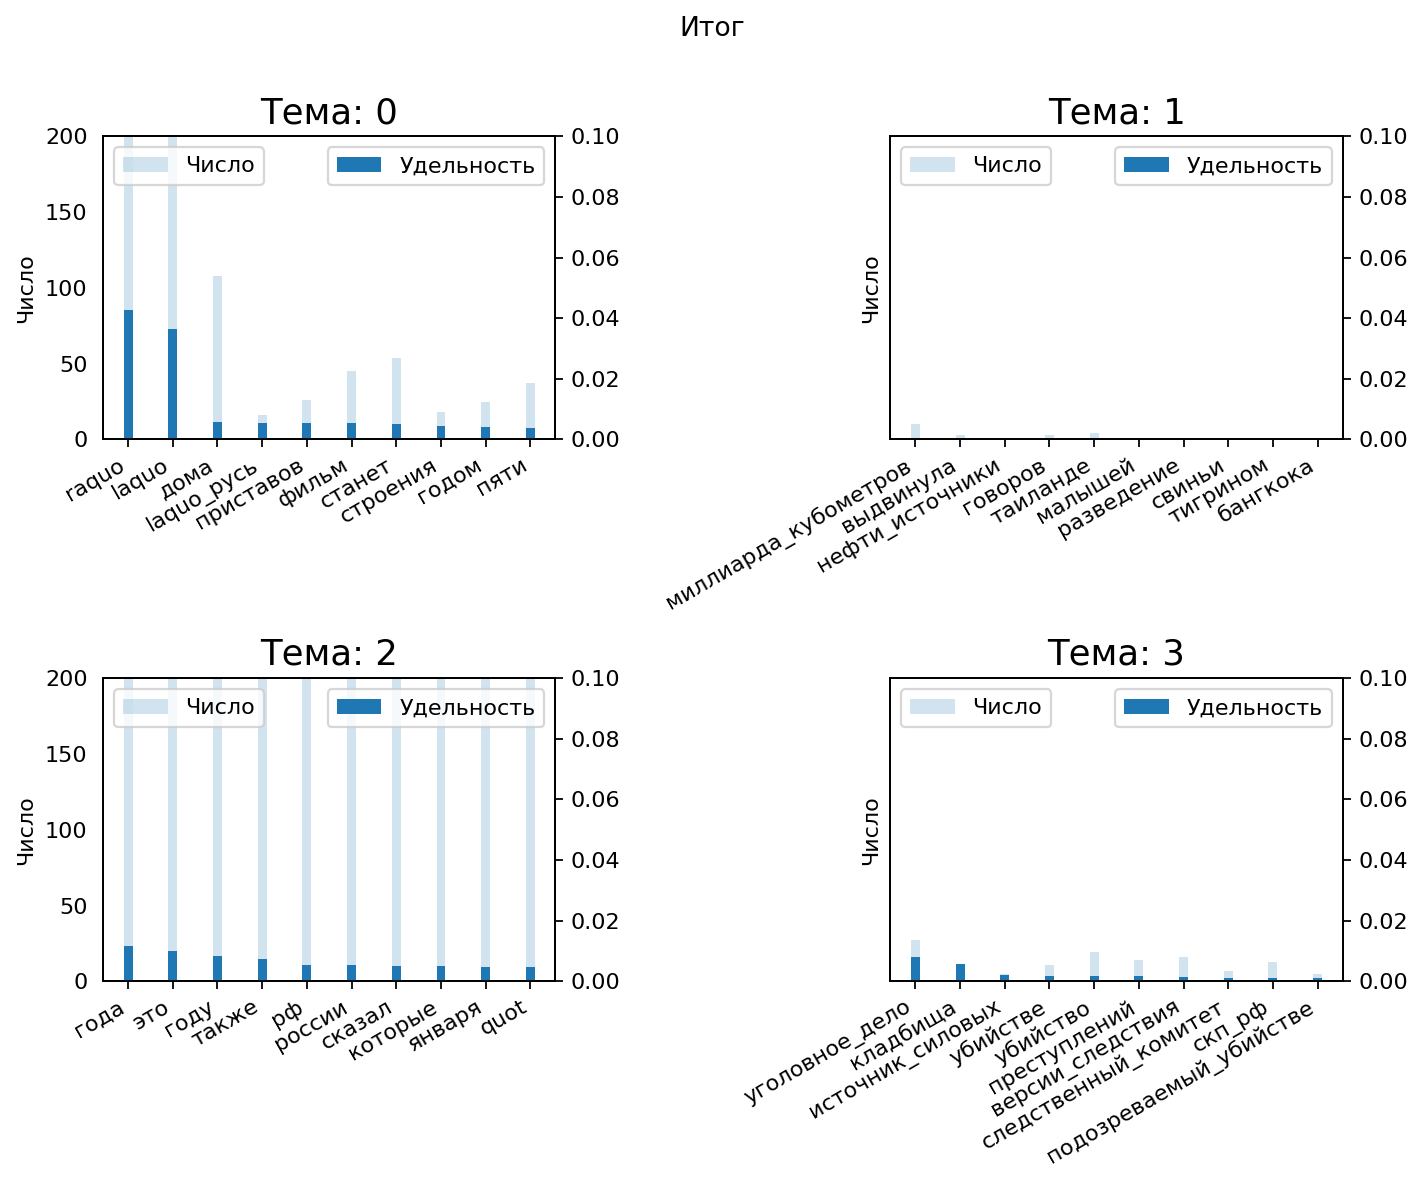

In [40]:
#диаграммы подсчёта частот слов
fig, axes = plt.subplots(2, 2, figsize=(9, 7), sharey=True, dpi=160)

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=out[i],  width=0.2, alpha=0.2, label='Число')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=out[i],  width=0.2, label='Удельность')
    ax.set_ylabel('Число')
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 200)
    ax.set_title('Тема: ' + str(i),  fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Итог', fontsize=12, y=1.05)    
plt.show()

In [ ]:
#установка PYLDAVIS для визуализации

!pip install gensim pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
!pip install pandas==1.5.3 #исправление ошибки

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Визуализация результаты работ LDA с помощью pyLDAvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word,  mds='mmds')
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.312120  0.279093       1        1  62.063033
6     -0.048256 -0.275830       2        1   9.116350
0     -0.248732 -0.090468       3        1   6.422063
5     -0.206331  0.163192       4        1   5.814136
7      0.170228 -0.169662       5        1   5.808676
8      0.120646 -0.023058       6        1   5.608513
4     -0.016011  0.161208       7        1   4.821246
3     -0.042775 -0.025017       8        1   0.266029
1     -0.040889 -0.019458       9        1   0.079955, topic_info=                  Term         Freq        Total Category  logprob  loglift
6063           вторник   496.000000   496.000000  Default  30.0000  30.0000
2149             raquo   487.000000   487.000000  Default  29.0000  29.0000
2148             laquo   415.000000   415.000000  Default  28.0000  28.0000
98                года  1265.000000  1265.000000  Default  27.0000  27.0000
900                это  1079.000000  1079.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
6235           финской     0.003224     1.717185   Topic9 -10.6889   0.8538
7680     поставок_газа     0.003224     5.656941   Topic9 -10.6889  -0.3384
1877   нижний_новгород     0.003224     2.249124   Topic9 -10.6889   0.5839
40749    военачальники     0.003224     0.805349   Topic9 -10.6889   1.6109
41469     девять_домов     0.003224     2.078175   Topic9 -10.6889   0.6629

[354 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
2148       3  0.997349            laquo
30217      3  0.988369       laquo_русь
4454       1  0.998058             quot
2149       3  0.999376            raquo
9880       2  0.995141           авдеев
...      ...       ...              ...
1681       4  0.966271            шесть
25210      4  0.988367  эксплуатировать
900        1  0.999128              это
906        1  0.996379         является
1337       1  0.999703           января

[285 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 1, 6, 8, 9, 5, 4, 2])